In [1]:
import arviz as az
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
import numpy as np
import preliz as pz
import pymc as pm
from scipy.special import betaln

In [2]:
az.style.use('arviz-doc')

# Model comparison

## Post hoc predictive tests
- Way to evaluate how well the model captures the data
- Better understand the limitations of the model
  - Take them into account
  - Improve the model
- Bayesian p-value
  - Numerical way of comparing simulated and real data
  - Summary statistic $T$ choosen (mean, median)
  - $T$ is calculated for the observed and simulated data
  - What is the probability that $T_{simulated}$ is less or equal than $T_{observed}$? If both agree, the expected value is $0.5$
  - Bayesian p-value=$p(T_{sim} \leq T_{obs}|\tilde{Y})$

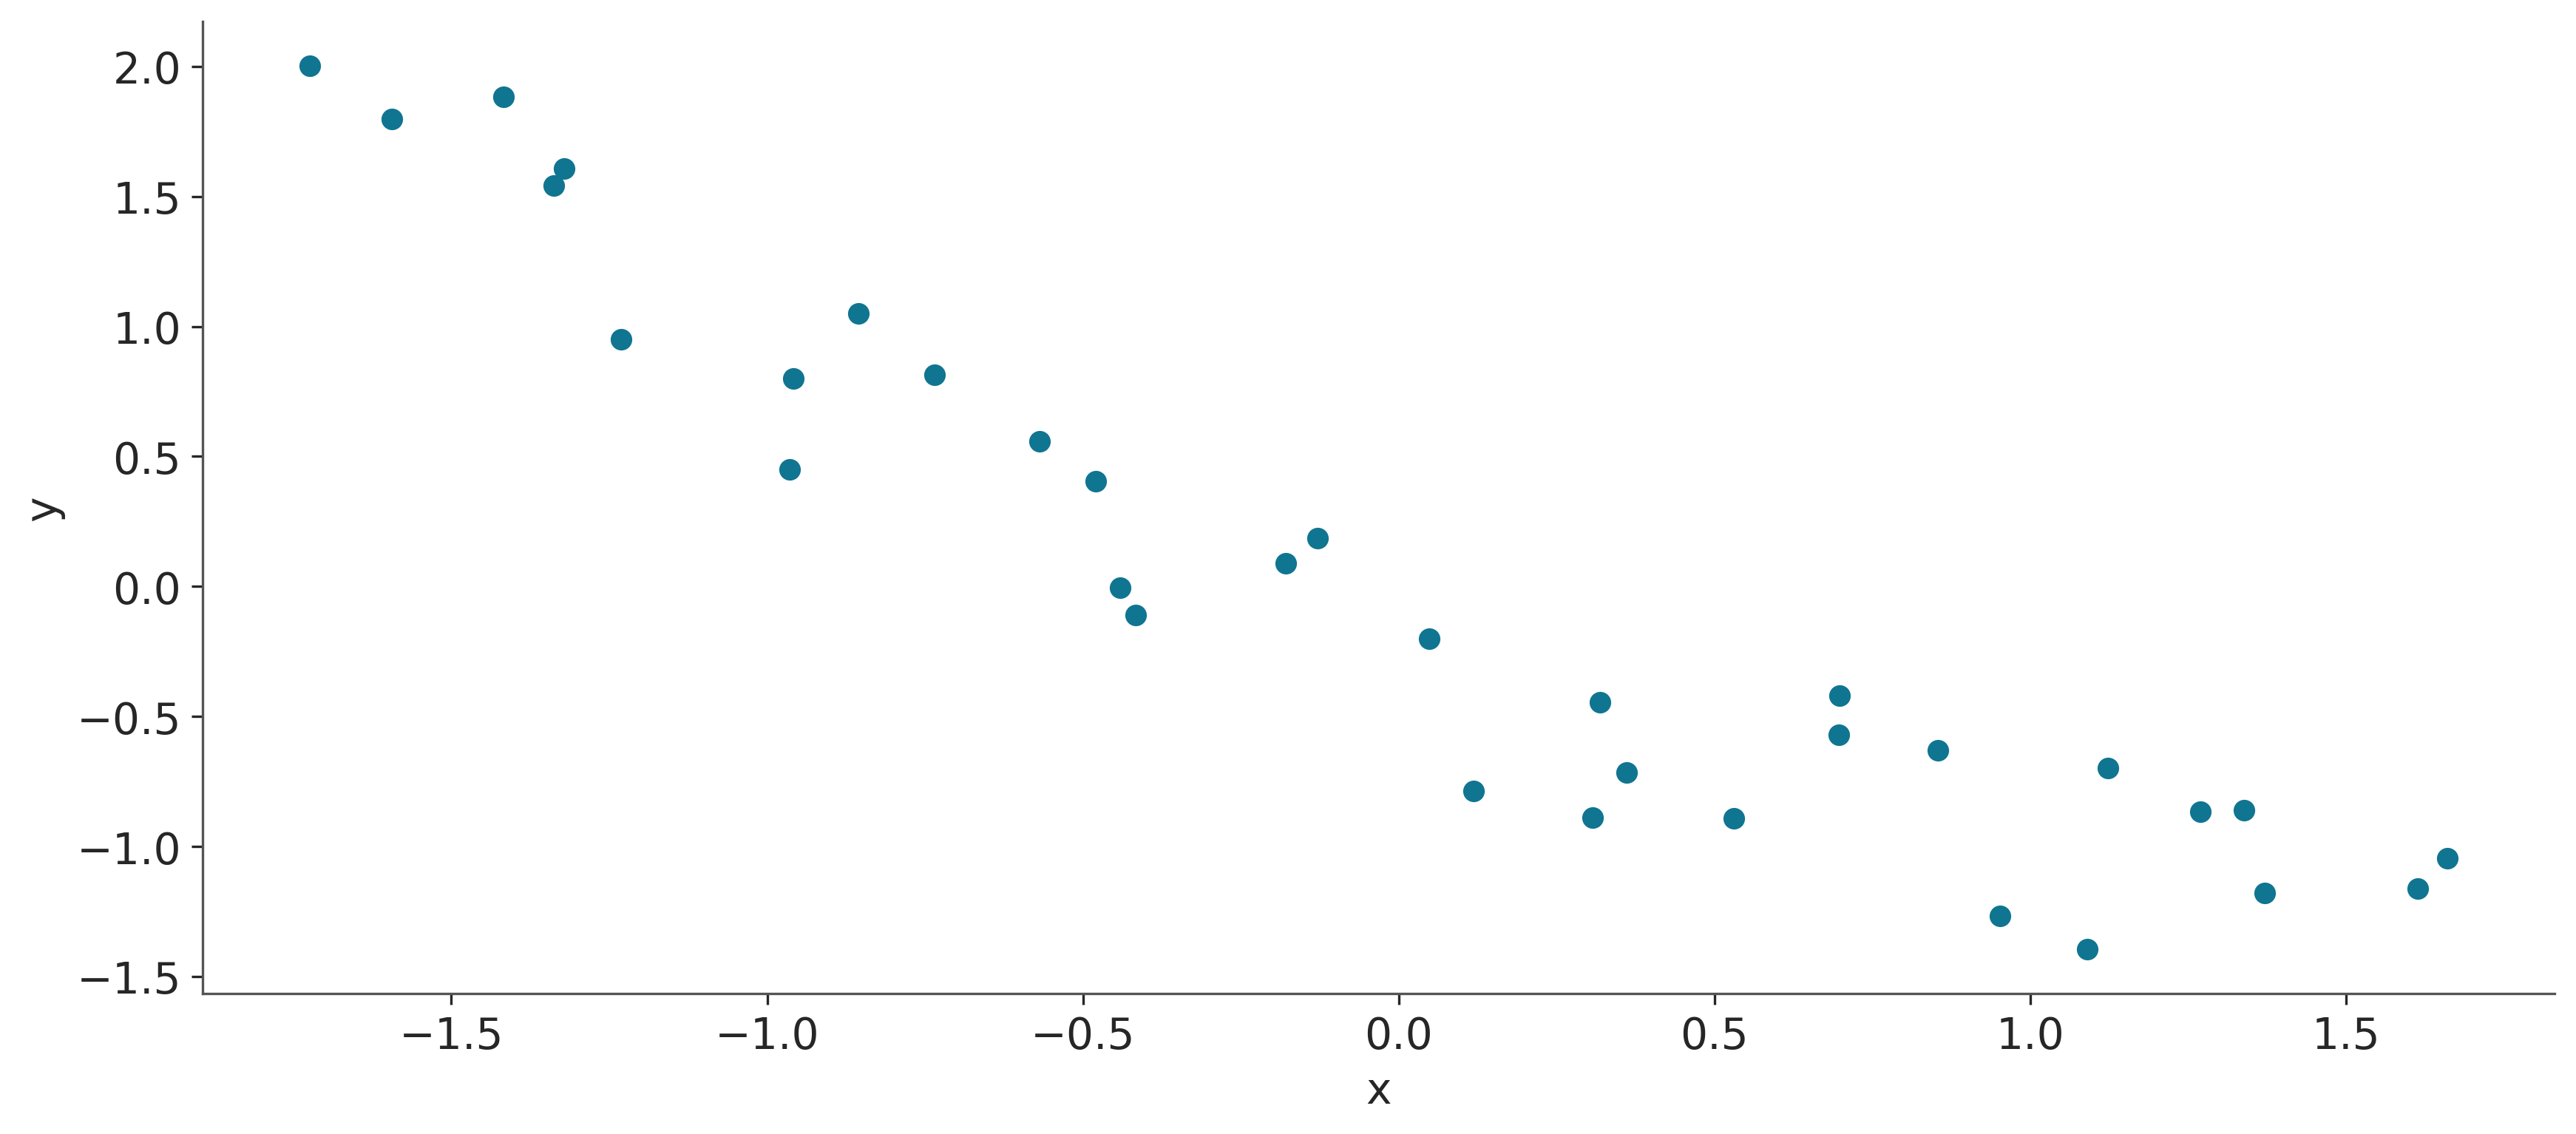

In [3]:
dummy_data = np.loadtxt('data/dummy.csv')
x = dummy_data[:,0]
y = dummy_data[:,1]

order = 2
x_p = np.vstack([x**i for i in range(1, order+1)])
x_c = (x_p - x_p.mean(axis=1, keepdims=True)) / x_p.std(axis=1, keepdims=True)
y_c = (y - y.mean()) / y.std()
plt.scatter(x_c[0], y_c)
plt.xlabel('x')
plt.ylabel('y');

In [4]:
with pm.Model() as model_l:
    α = pm.Normal('α', mu=0, sigma=1)
    β = pm.Normal('β', mu=0, sigma=10)
    σ = pm.HalfNormal('σZ', 5)

    μ = α + β * x_c[0]
    
    y_pred = pm.Normal('y_pred', mu=μ, sigma=σ, observed=y_c)

    idata_l = pm.sample(2000, idata_kwargs={"log_likelihood": True})
    idata_l.extend(pm.sample_posterior_predictive(idata_l))

with pm.Model() as model_p:
    α = pm.Normal('α', mu=0, sigma=1)
    β = pm.Normal('β', mu=0, sigma=10, shape=order)
    σ = pm.HalfNormal('σ', 5)

    μ = α + pm.math.dot(β, x_c)
    
    y_pred = pm.Normal('y_pred', mu=μ, sigma=σ, observed=y_c)

    idata_p = pm.sample(2000, idata_kwargs={"log_likelihood": True})
    idata_p.extend(pm.sample_posterior_predictive(idata_p))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [α, β, σZ]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 38 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Sampling: [y_pred]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [α, β, σ]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 33 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Sampling: [y_pred]


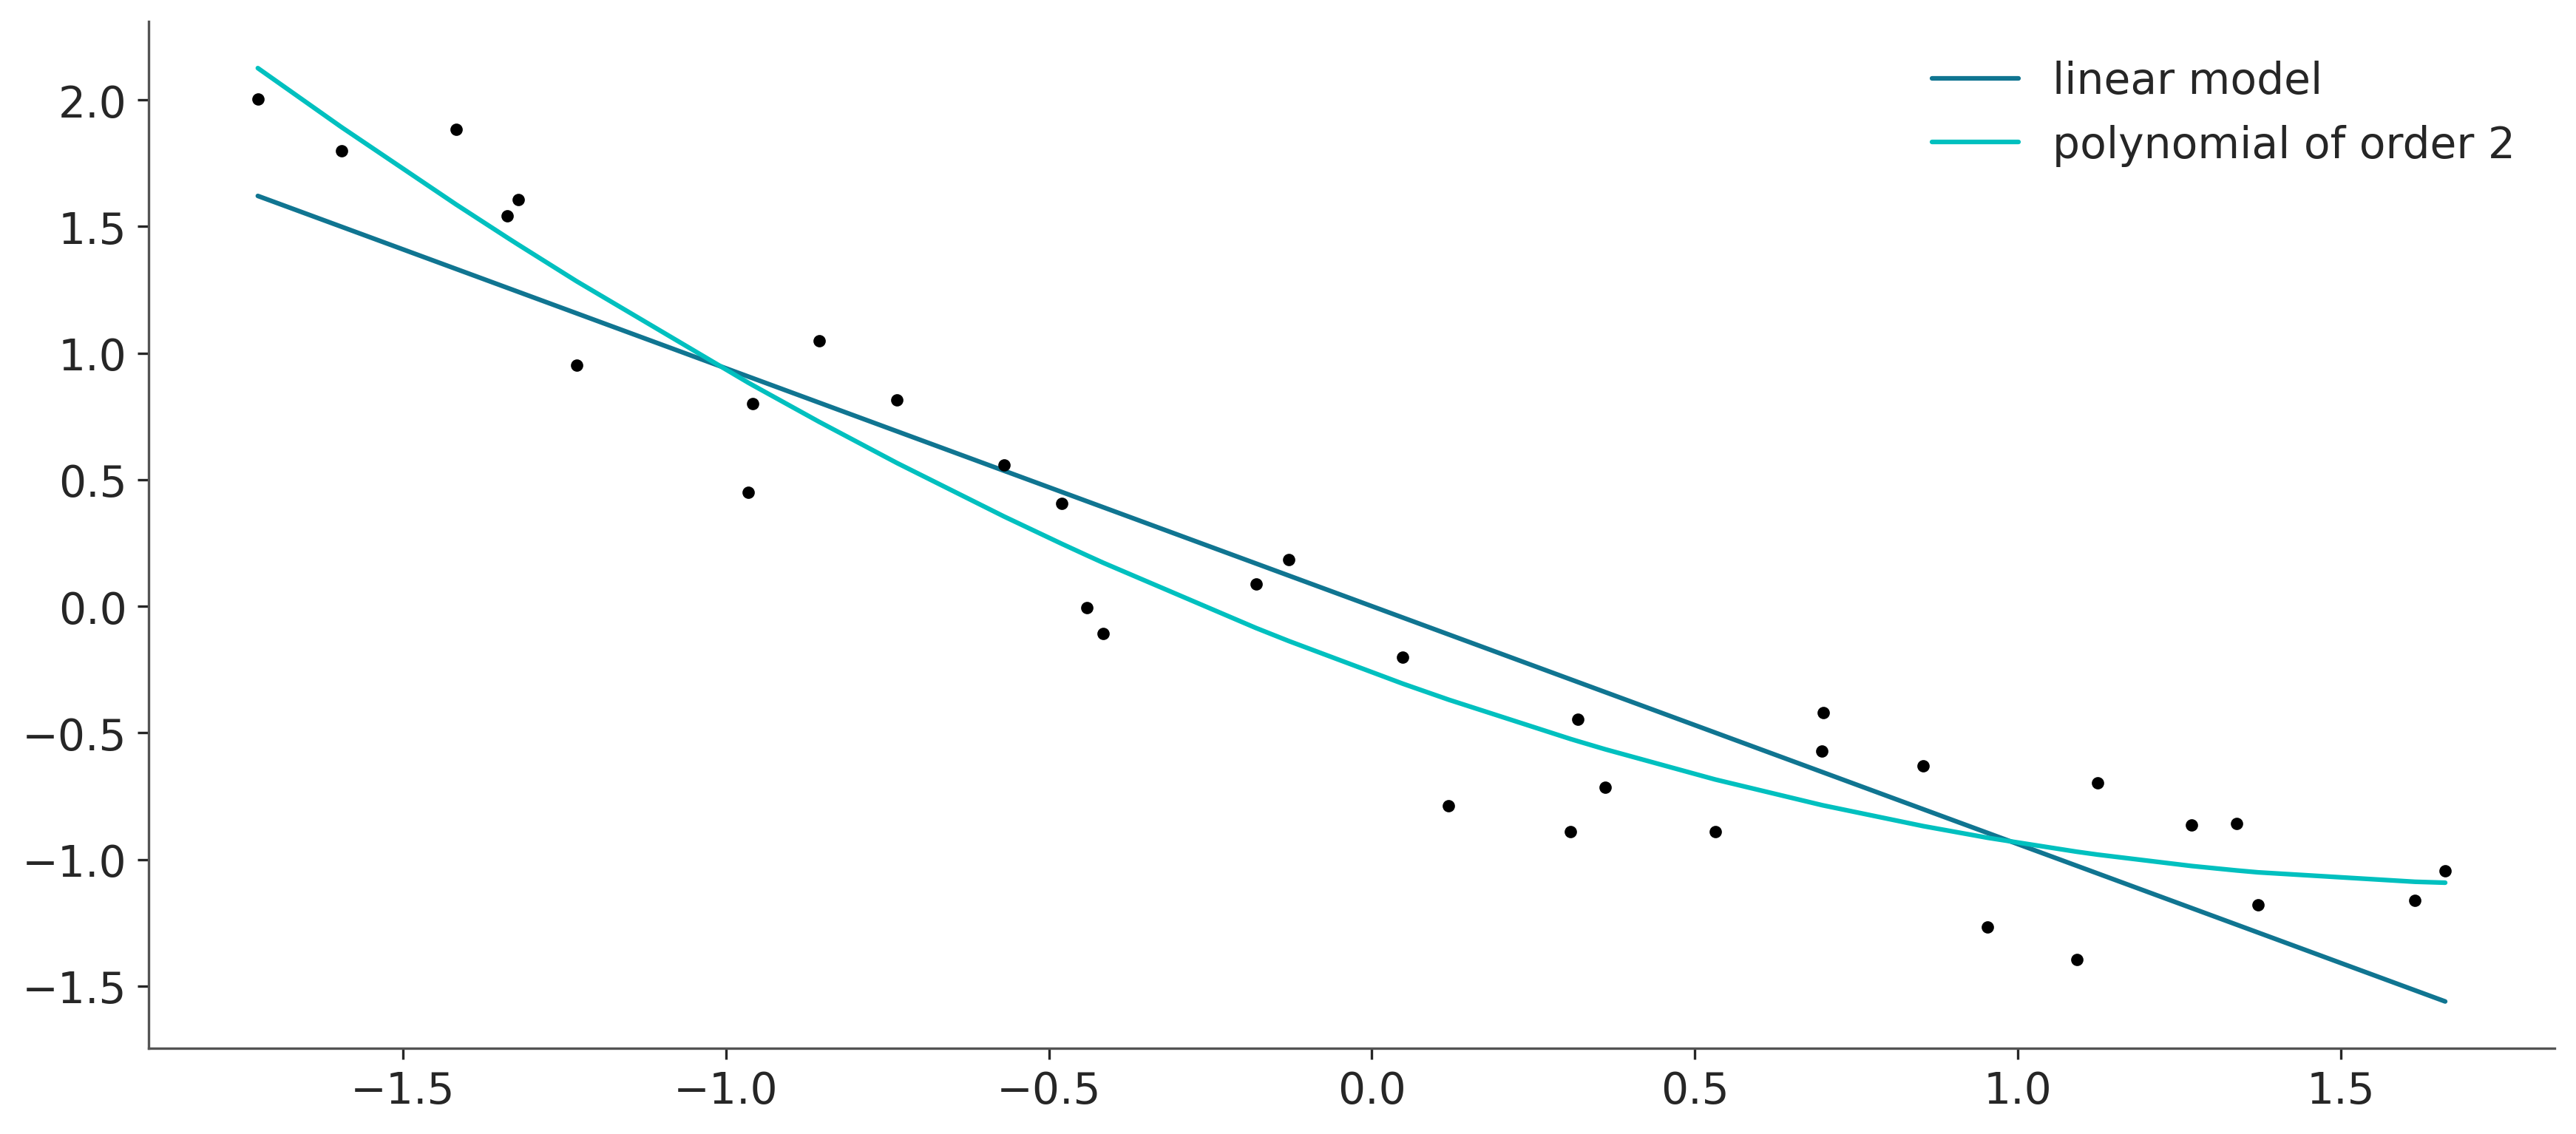

In [5]:
x_new = np.linspace(x_c[0].min(), x_c[0].max(), 100)

posterior_l = az.extract(idata_l)
posterior_p = az.extract(idata_p)

α_l_post = posterior_l['α'].mean().item()
β_l_post = posterior_l['β'].mean().item()
y_l_post = α_l_post + β_l_post *  x_new

plt.plot(x_new, y_l_post, 'C0', label='linear model')

α_p_post = posterior_p['α'].mean().item()
β_p_post = posterior_p['β'].mean("sample")
idx = np.argsort(x_c[0])
y_p_post = α_p_post + np.dot(β_p_post, x_c)

plt.plot(x_c[0][idx], y_p_post[idx], 'C1', label=f'polynomial of order {order}')

plt.plot(x_c[0], y_c, "k.")
plt.legend();

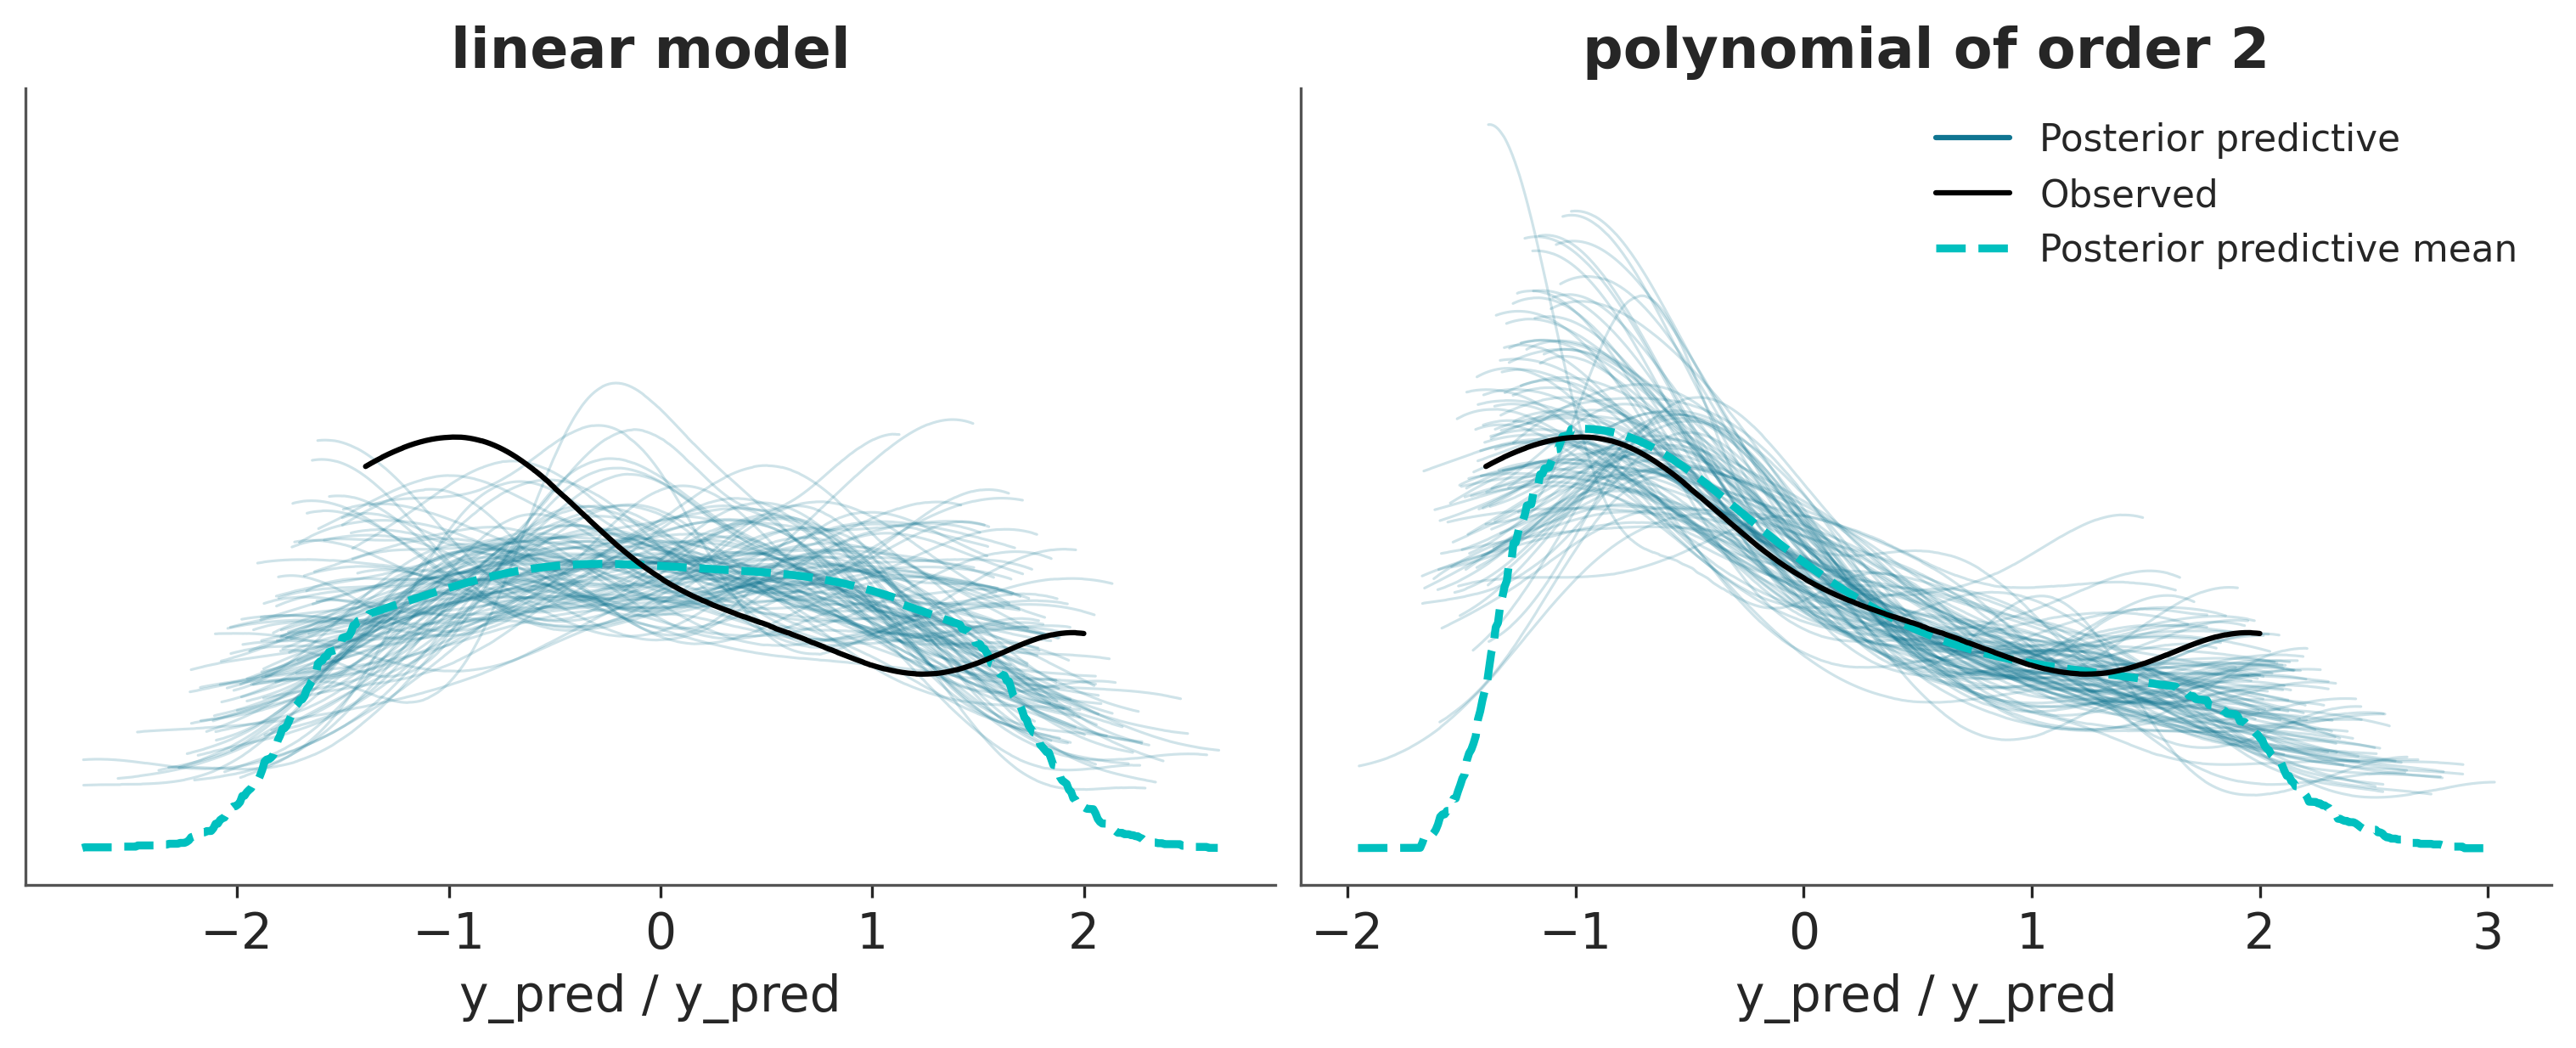

In [6]:
_, axes = plt.subplots(1, 2, figsize=(10, 4), sharey=True)
az.plot_ppc(idata_l, num_pp_samples=100, ax=axes[0], legend=False)
axes[0].set_title('linear model')
az.plot_ppc(idata_p, num_pp_samples=100, ax=axes[1]);
axes[1].set_title(f'polynomial of order {order}');

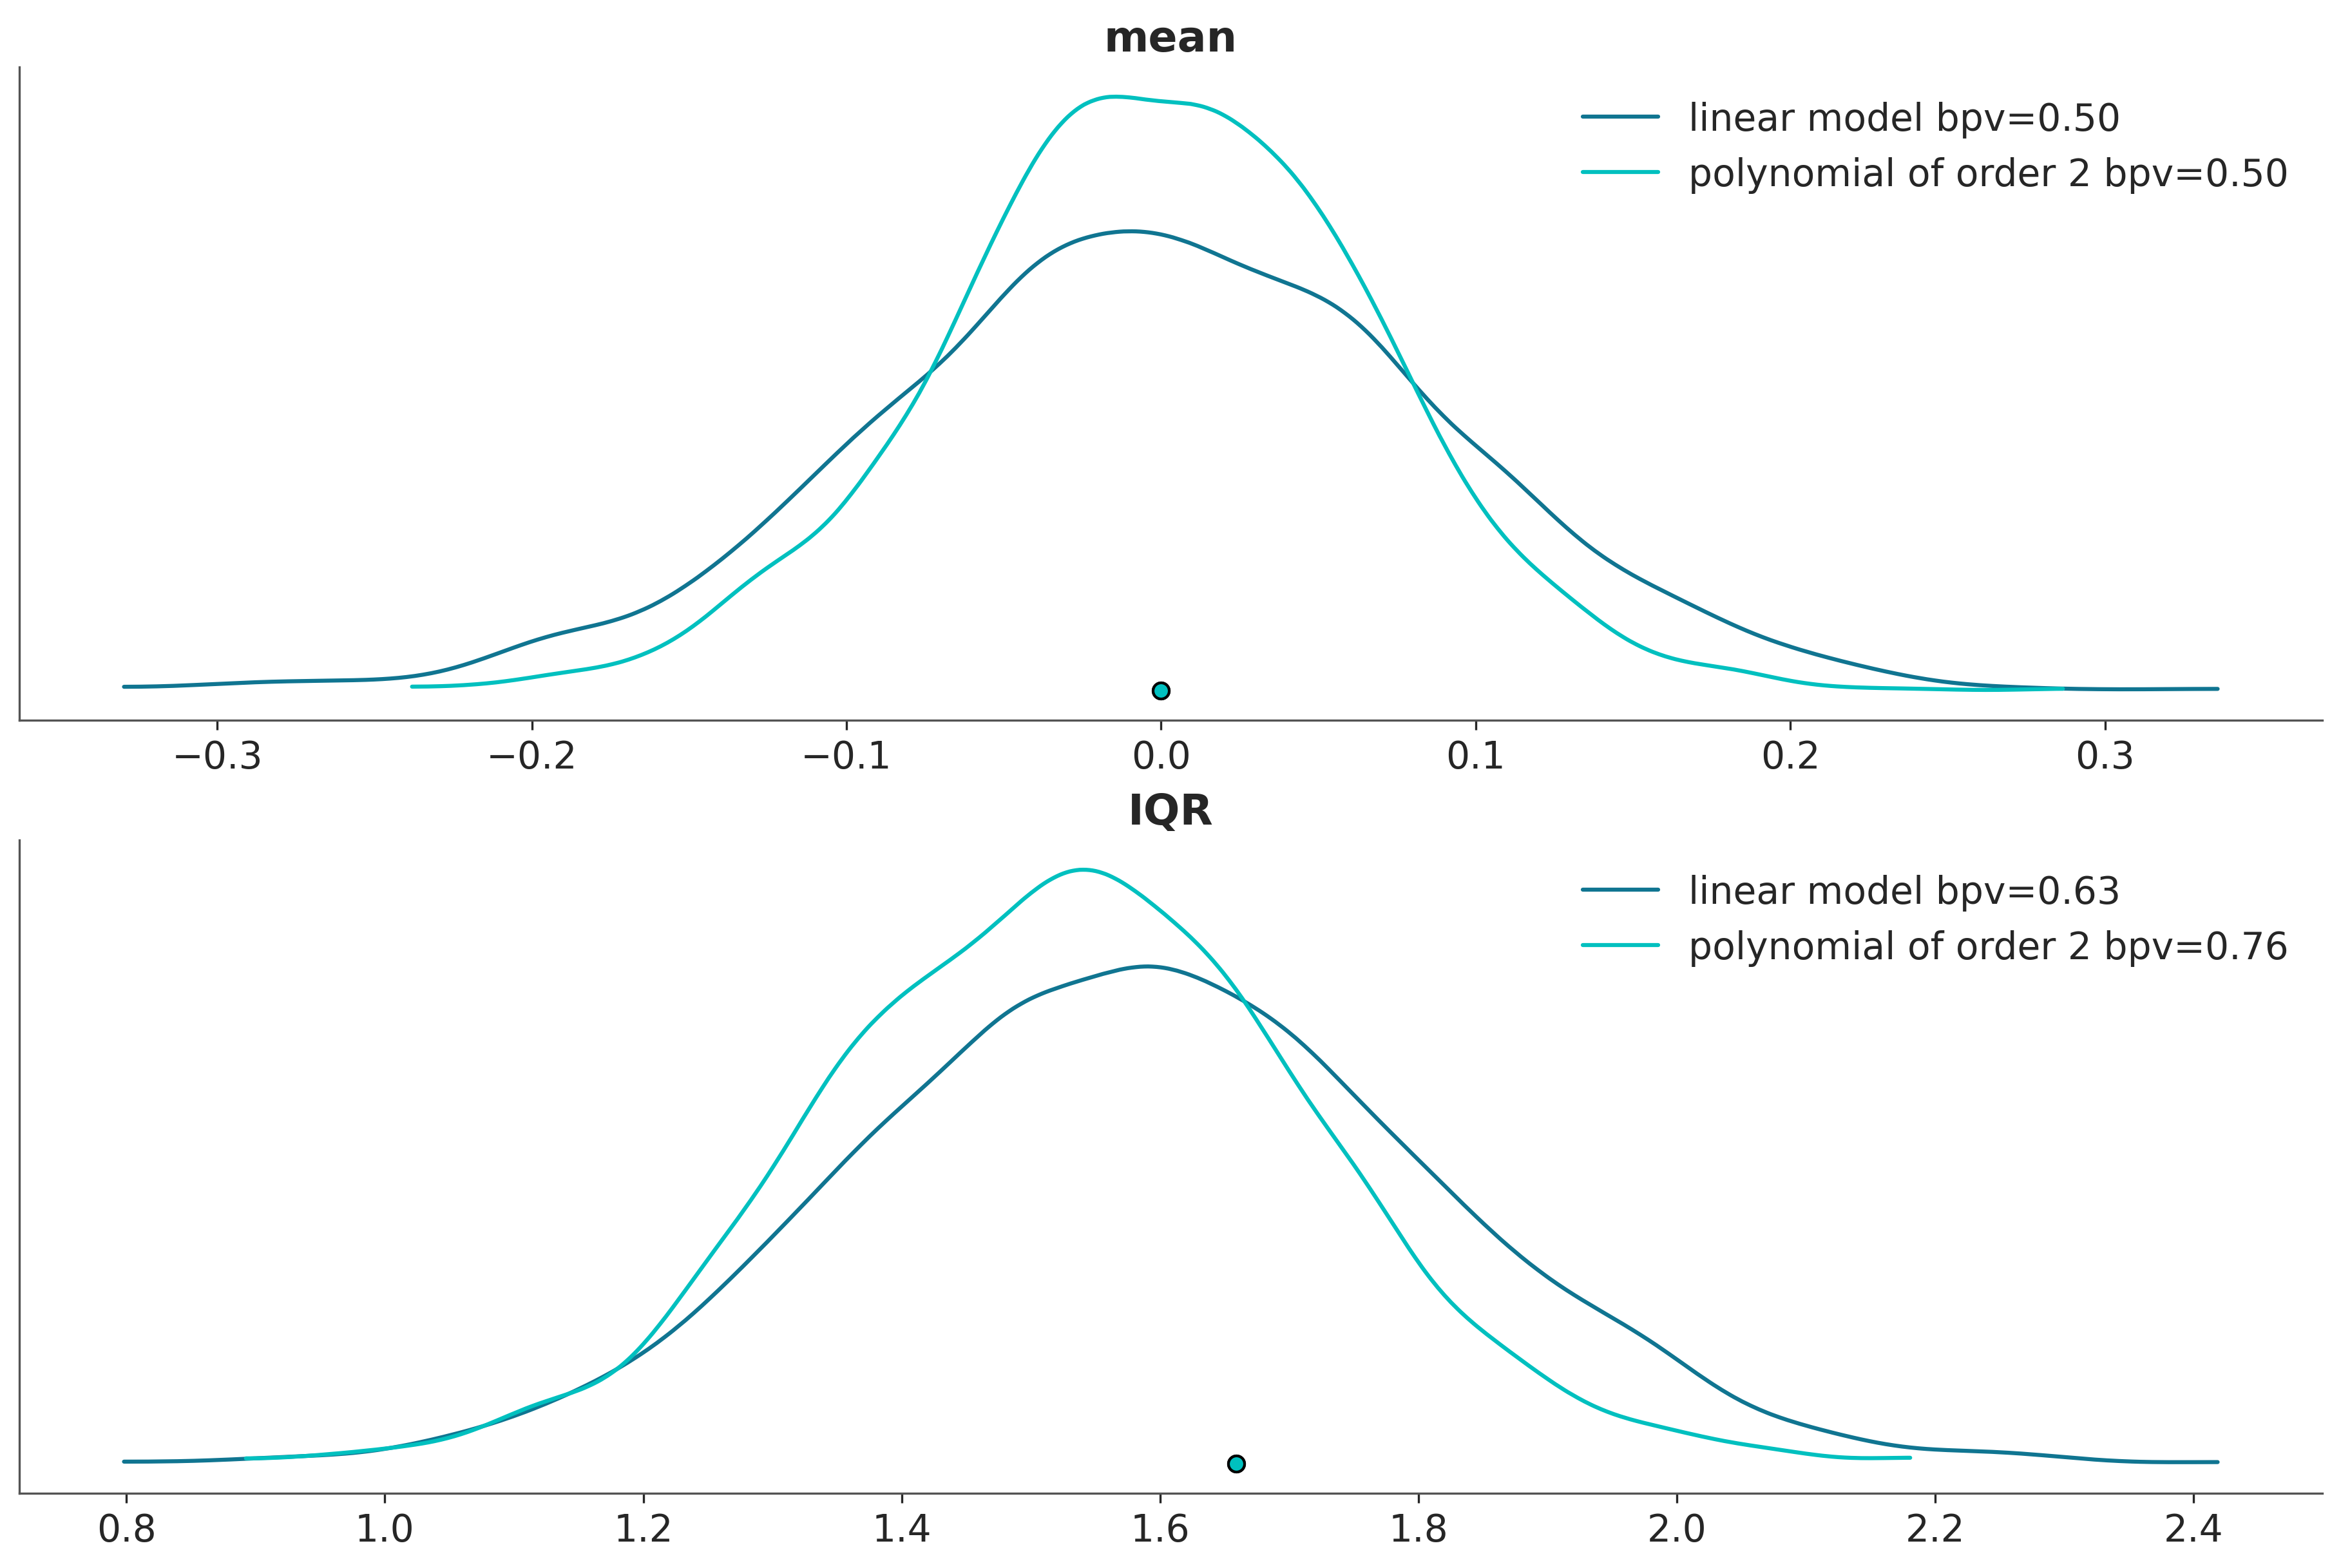

In [7]:
fig, axes = plt.subplots(2, 1, figsize=(12, 8), sharey="row")
colors = ["C0", "C1"]
titles = ["mean", "IQR"]
modelos = ['linear model', f'polynomial of order {order}']
idatas = [idata_l, idata_p]

def iqr(x, a=-1):
    return np.subtract(*np.percentile(x, [75, 25], axis=a))

for idata, c in zip(idatas, colors):
    az.plot_bpv(idata, kind="t_stat", t_stat="mean", ax=axes[0], color=c)
    

for idata, c in zip(idatas, colors):
    az.plot_bpv(idata, kind="t_stat", t_stat=iqr, ax=axes[1], color=c)

for ax, title, in zip(axes, titles):
    ax.set_title(title)
    for idx, (c, modelo) in enumerate(zip(colors, modelos)):
        ax.legend_.legend_handles [idx]._alpha = 1
        ax.legend_.legend_handles [idx]._color = c
        ax.legend_._loc = 1
        ax.legend_.texts[idx]._text = modelo + " " + ax.legend_.texts[idx]._text

## Balance between simplicity/accuracy
- Occam's razor
  - Given two explanations about the same phenomenon, the simpler one should be choosen
  - Common criteria for simplicity is the number of parameters of a model
- Many parameters can lead to overfitting
  - For example, a polynomial of degree $5$ can fit perfectly a data with $6$ points (it has the same number of parameters as data points)
  - Dataset has two components: Signal and noise
    - Signal: What we want to capture
    - Noise: Product of measurement erros, limitations in the way data is gathered
    - A model overfits when it's so flexible that it can capture the noise
  - Two few parameters leads to underfitting

## Predictive accuracy measures
- Whitin-sample accuracy: Accuracy measured with the same data used to fit the model
- Out-of-sample accuracy: Accuracy measured with data not used to fit the model. Better to understand generalization. Requires using less data to train the model. Two solutions
  - Cross-validation: Divide data in subsets and used to fit/evaluate alternatively
  - Information criteria: 
    - General term that approximate out-of-sample accuracy as in sample accuracy + a term that penalizes model complexity
    - Log-likelihood: $\sum_{i}^n log p(y_{i}|\theta)$. When p is Gaussian, it's equivalent to MSE.
    - Akaike Information Criteira (AIC)
      - $-2\sum_{i}^n log p(y_{i} | \hat{ \theta_{mle}}) + 2k$, where $k$ is the number of parameters and $\hat{\theta_{mle}}$ it's the point estimate from the model
      - Problematic for Bayesian models
        - It doesnt use whole posterior distribution, just the point estimate
        - Number of parameters is not a good measure for bayesian models
    - **WAIC** (Widely applicable information criteria)
      - Like Bayesian version of AIC
      - $-2\sum_{i}^n log(\frac{1}{S}\sum_{i}^S p(y_{i}|\theta^s)) + 2\sum_{i}^n(V_{s=1}^S log p(y_{i}|\theta^s))$
      - First term is similar to AIC, but its evaluated for all samples and all posterior samples
      - Way to penalize complexity of the model
      - WAIC uses the entire posterior
    - Approximated cross-validation
      - Importance sampling using Paretto smoothing
        - $ELPD_{LOO-CV} = \sum_{i=1}^n log \int p(y_{i}|\theta) * p(\theta|y_{-i})d\theta$
        - $\sum_{i}^n log(\frac{1}{s} \sum_{j}^s p(y_{i}|\theta_{-i}^j))$
      - $-i$ means that we leave the observation $i$ outside
      - Its possible to approximate $p(y_{i}|\theta_{-i}^j)$ using importance sampling
        - Estimate the importance each observation has in determining the posterior distribution
        - An observation will be more important the more the posterior changes after removing it
        - Can be estimated without readjust the model, using $w_{s} = \frac{1}{p(y_{i}|\theta_{s})}$
        - Pareto smoothing comes in to replace some of those weights with weights obtained from fitting a Pareto distribution
          - Theory indicates that those weights should follow a Pareto
        - Values of $k$(one of the parameters of the Pareto distribution) above 0.7 indicates that we possibly have very large influential observations

## Calculating using Arviz

In [8]:
waic_l = az.waic(idata_l)
waic_l

C:\Users\Gabriel\AppData\Local\Temp\ipykernel_17072\3231444580.py:1: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  waic_l = az.waic(idata_l)


Computed from 4000 posterior samples and 33 observations log-likelihood matrix.

          Estimate       SE
elpd_waic   -14.29     2.66
p_waic        2.37        -

In [9]:
waic_p = az.waic(idata_p)
waic_p

C:\Users\Gabriel\AppData\Local\Temp\ipykernel_17072\1785964567.py:1: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  waic_p = az.waic(idata_p)


Computed from 4000 posterior samples and 33 observations log-likelihood matrix.

          Estimate       SE
elpd_waic    -4.55     2.35
p_waic        2.65        -

In [10]:
loo_l = az.loo(idata_l)
loo_l

C:\Users\Gabriel\AppData\Local\Temp\ipykernel_17072\4096219285.py:1: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  loo_l = az.loo(idata_l)


Computed from 4000 posterior samples and 33 observations log-likelihood matrix.

         Estimate       SE
elpd_loo   -14.32     2.67
p_loo        2.40        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)       33  100.0%
 (0.5, 0.7]   (ok)          0    0.0%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%

In [11]:
loo_p = az.loo(idata_p)
loo_p

C:\Users\Gabriel\AppData\Local\Temp\ipykernel_17072\131992615.py:1: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  loo_p = az.loo(idata_p)


Computed from 4000 posterior samples and 33 observations log-likelihood matrix.

         Estimate       SE
elpd_loo    -4.59     2.35
p_loo        2.69        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)       33  100.0%
 (0.5, 0.7]   (ok)          0    0.0%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%

- Rank: Order of the models, from best to worst
- elpd - point estimate from elpd
- p: Effective parameters
- weight: Relative weight of each model
- warning: About high $k$ values

In [12]:
cmp_df = az.compare({'modelo_l':idata_l, 'modelo_p':idata_p})
cmp_df

c:\Users\Gabriel\mambaforge\envs\bayes\lib\site-packages\arviz\stats\stats.py:307: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'False' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_comp.loc[val] = (
c:\Users\Gabriel\mambaforge\envs\bayes\lib\site-packages\arviz\stats\stats.py:307: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'log' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_comp.loc[val] = (


,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
modelo_p,0,-4.589508,2.685733,0.000000,1.000000e+00,2.351142,0.000000,False,log
modelo_l,1,-14.322805,2.404323,9.733298,1.421085e-14,2.665028,2.671047,False,log


c:\Users\Gabriel\mambaforge\envs\bayes\lib\site-packages\arviz\plots\backends\matplotlib\compareplot.py:87: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  scale = comp_df["scale"][0]


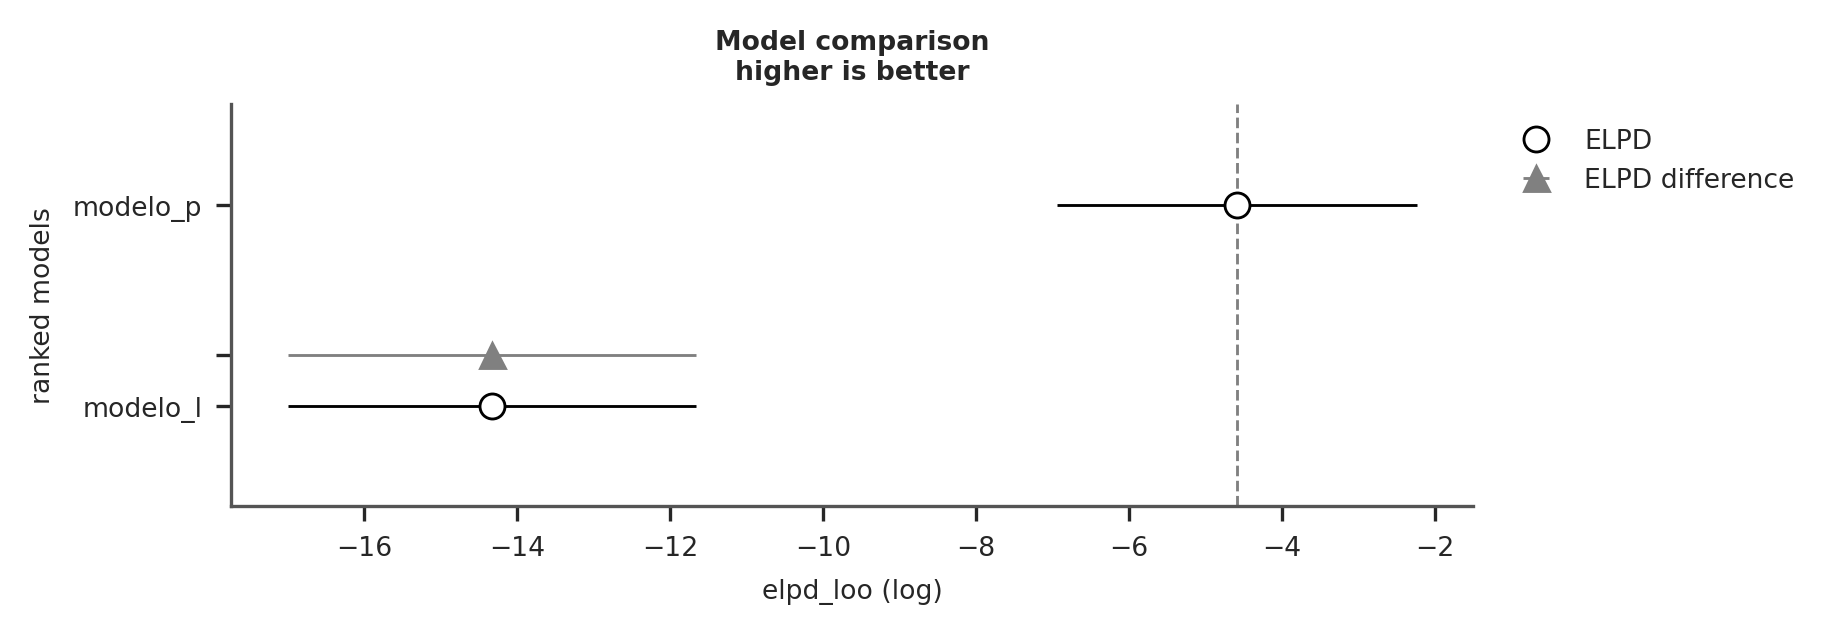

In [13]:
az.plot_compare(cmp_df);

## Model average
- Possibilty is to average different models
- Uncertainty we have in the goodness of each model

In [14]:
idata_w = az.weight_predictions(idatas, weights=[0.35, 0.65])

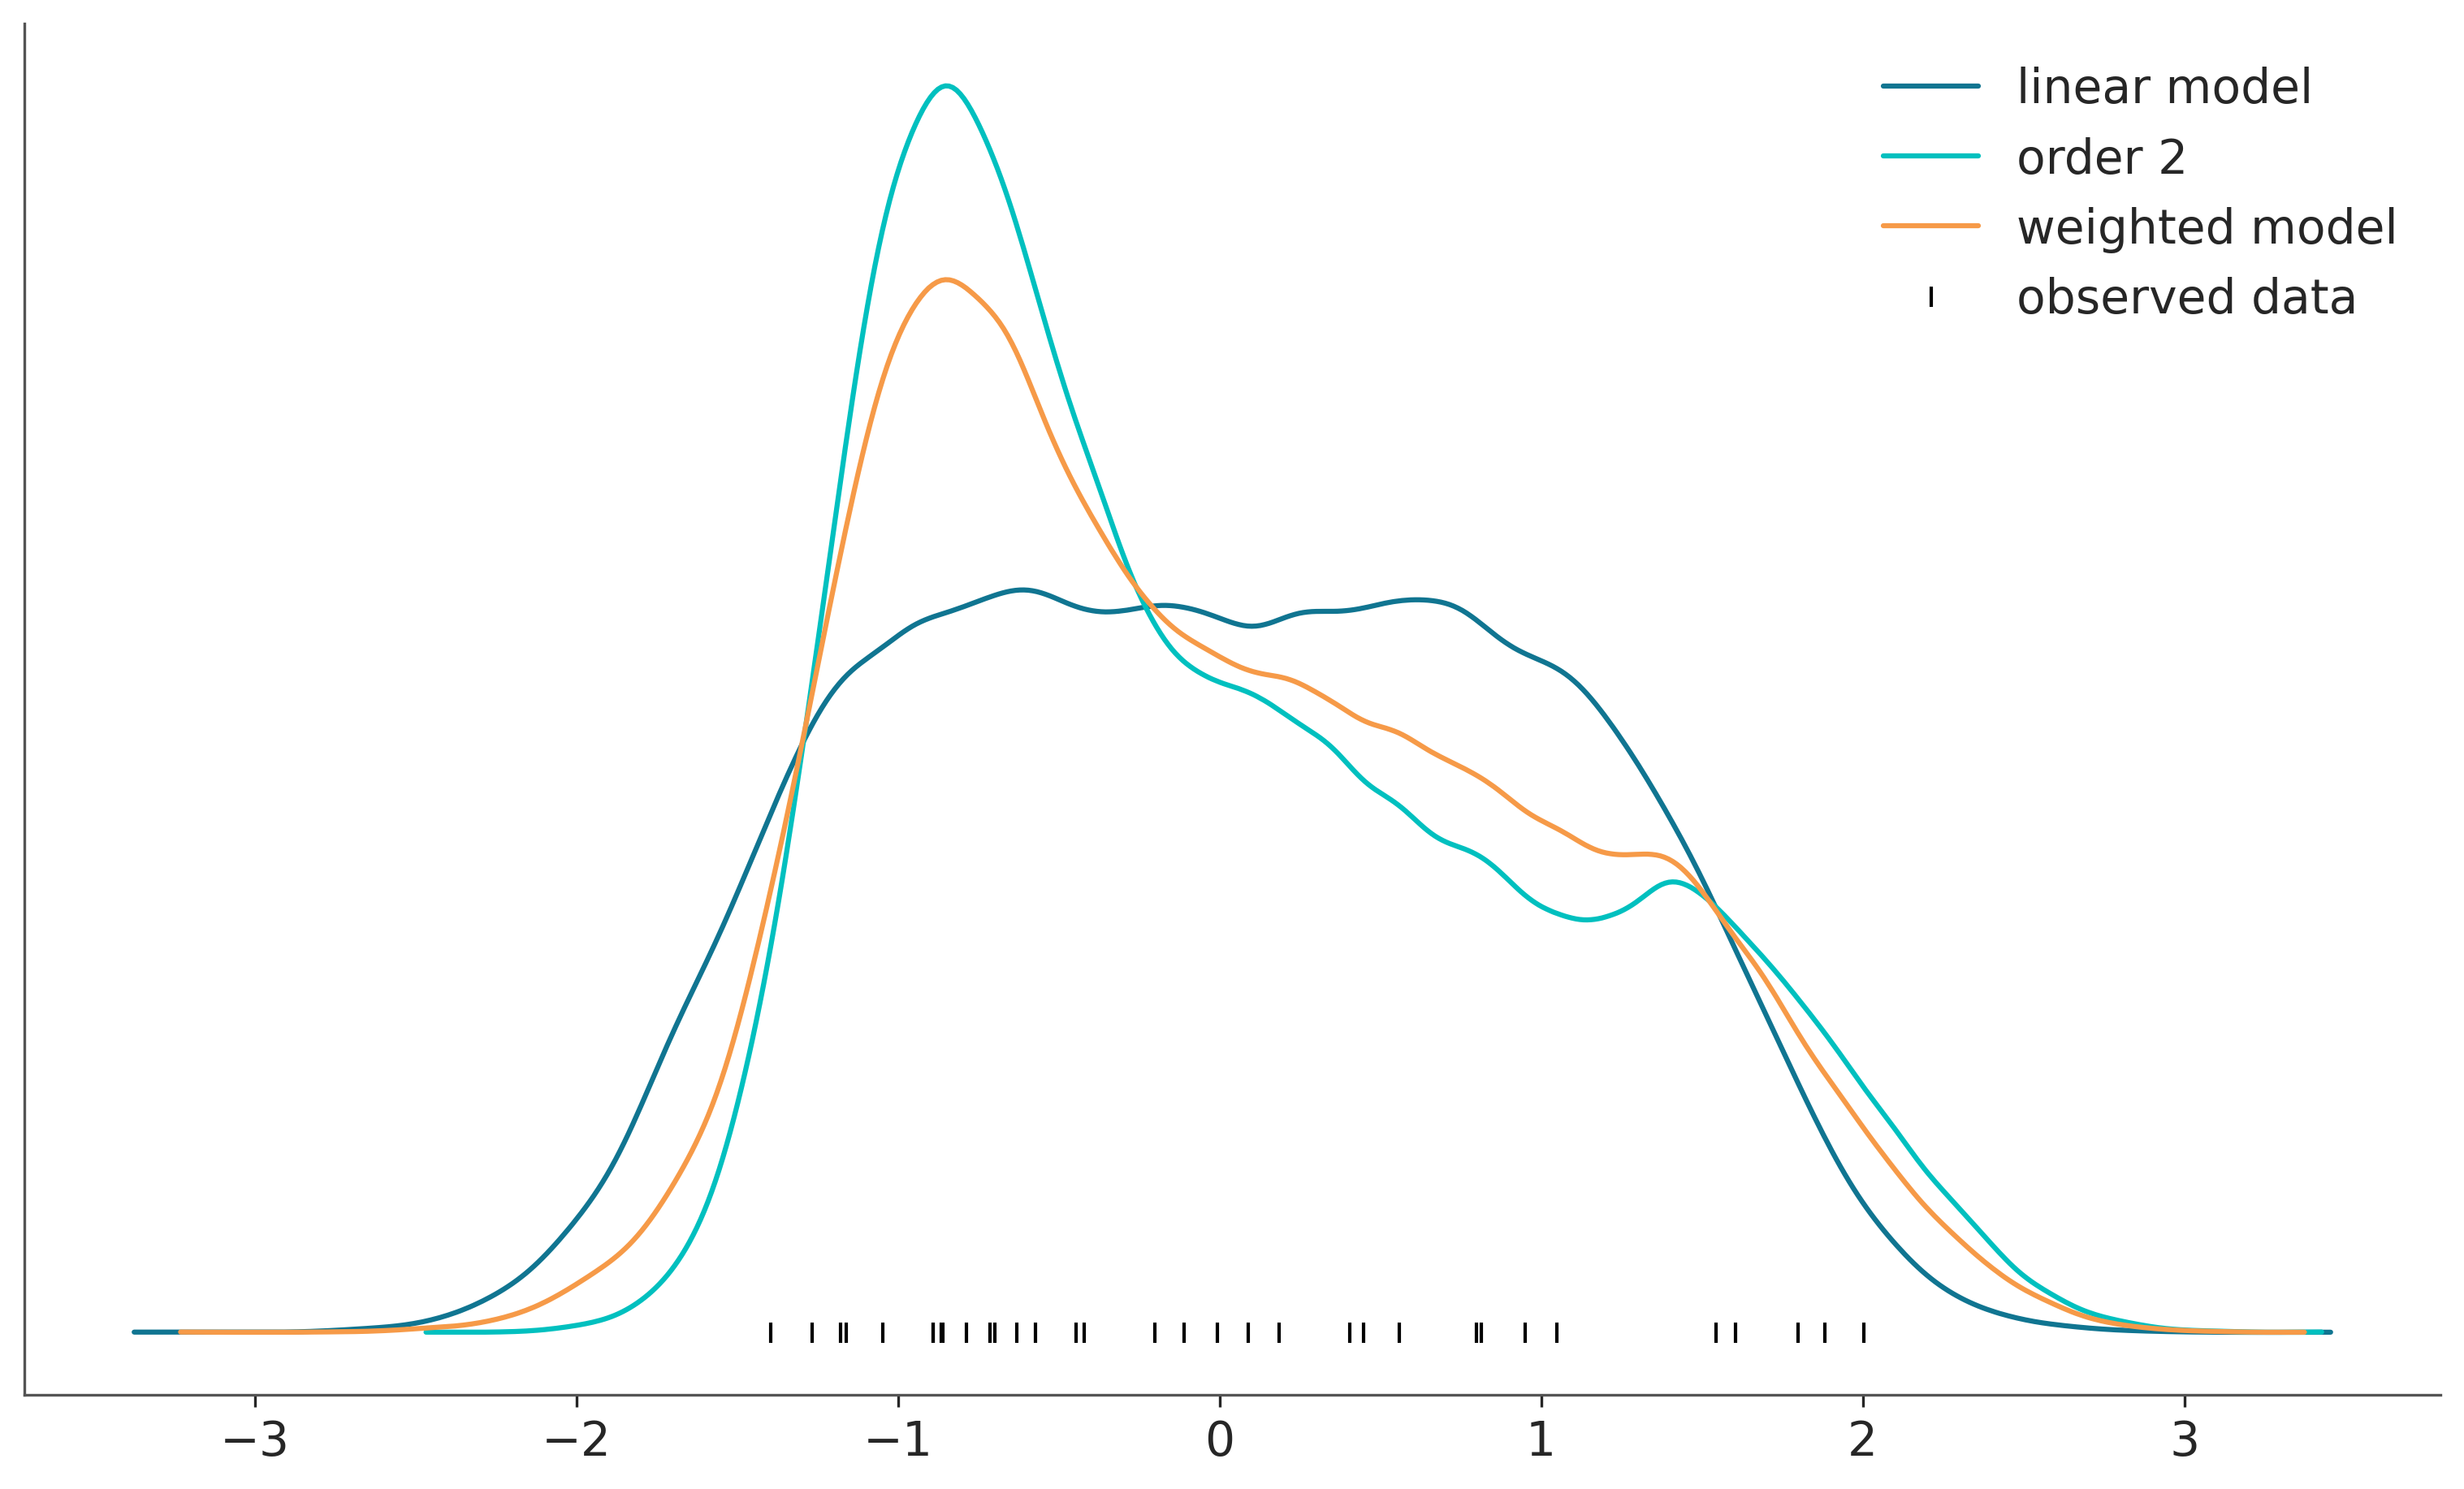

In [15]:
_, ax = plt.subplots(figsize=(10, 6))
az.plot_kde(idata_l.posterior_predictive['y_pred'].values, plot_kwargs={'color':'C0'}, label='linear model', ax=ax)
az.plot_kde(idata_p.posterior_predictive['y_pred'].values, plot_kwargs={'color':'C1'}, label='order 2', ax=ax)
az.plot_kde(idata_w.posterior_predictive['y_pred'].values, plot_kwargs={'color':'C2'}, label='weighted model', ax=ax)

plt.plot(y_c, np.zeros_like(y_c), 'k|', label='observed data')
plt.yticks([])
plt.legend();

## Bayes factor
- Appear in literature as bayesian view of frequentist hypotesis testing
- Bayesian way of comparing $k$ models
  - Marginal likelihood of each model $p(y|M_{k})$, probability of observed data given model $M_{k}$ $$p(\theta|Y,M_{k}) = \frac{p(y|\theta,M_{k})p(\theta|M_{k})}{p(Y|M_{k})}$$
  - Choose best model: Highest of $p(y|M_{k})$
  - $FB_{01} = \frac{p(y|M_{0})}{p(y|M_{1})}$
  - Scale of interpretation
    - 1-3: Anecdotal
    - 3-10: Moderate
    - 10-30: Strong
    - 30-100: Very strong
    - greather than 100: Extreme
- Marginal likelihood:
  - Models with more parameters have a larger penalty than models with few parameters
  - Hard to be calculated analytically
  - Depends very sensitively on the prior distribution of the parameters in each model $p(\theta_{k}$

## Savage-Dickey coefficient
- Null hypothesis vs True hypothesis $$BF_{01} = \frac{p(y|H_{0})}{p(y|H_{1})}\frac{p(\theta=0.5|y,H_{1})}{p(\theta=0.5|H_{1})}$$

In [18]:
y = np.repeat([1, 0], [50, 50])  

In [19]:
with pm.Model() as model_uni:
    a = pm.Beta("a", 1, 1)
    yl = pm.Bernoulli("yl", a, observed=y)
    idata_uni = pm.sample(2000, random_seed=42)
    idata_uni.extend(pm.sample_prior_predictive(8000))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [a]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 38 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Sampling: [a, yl]


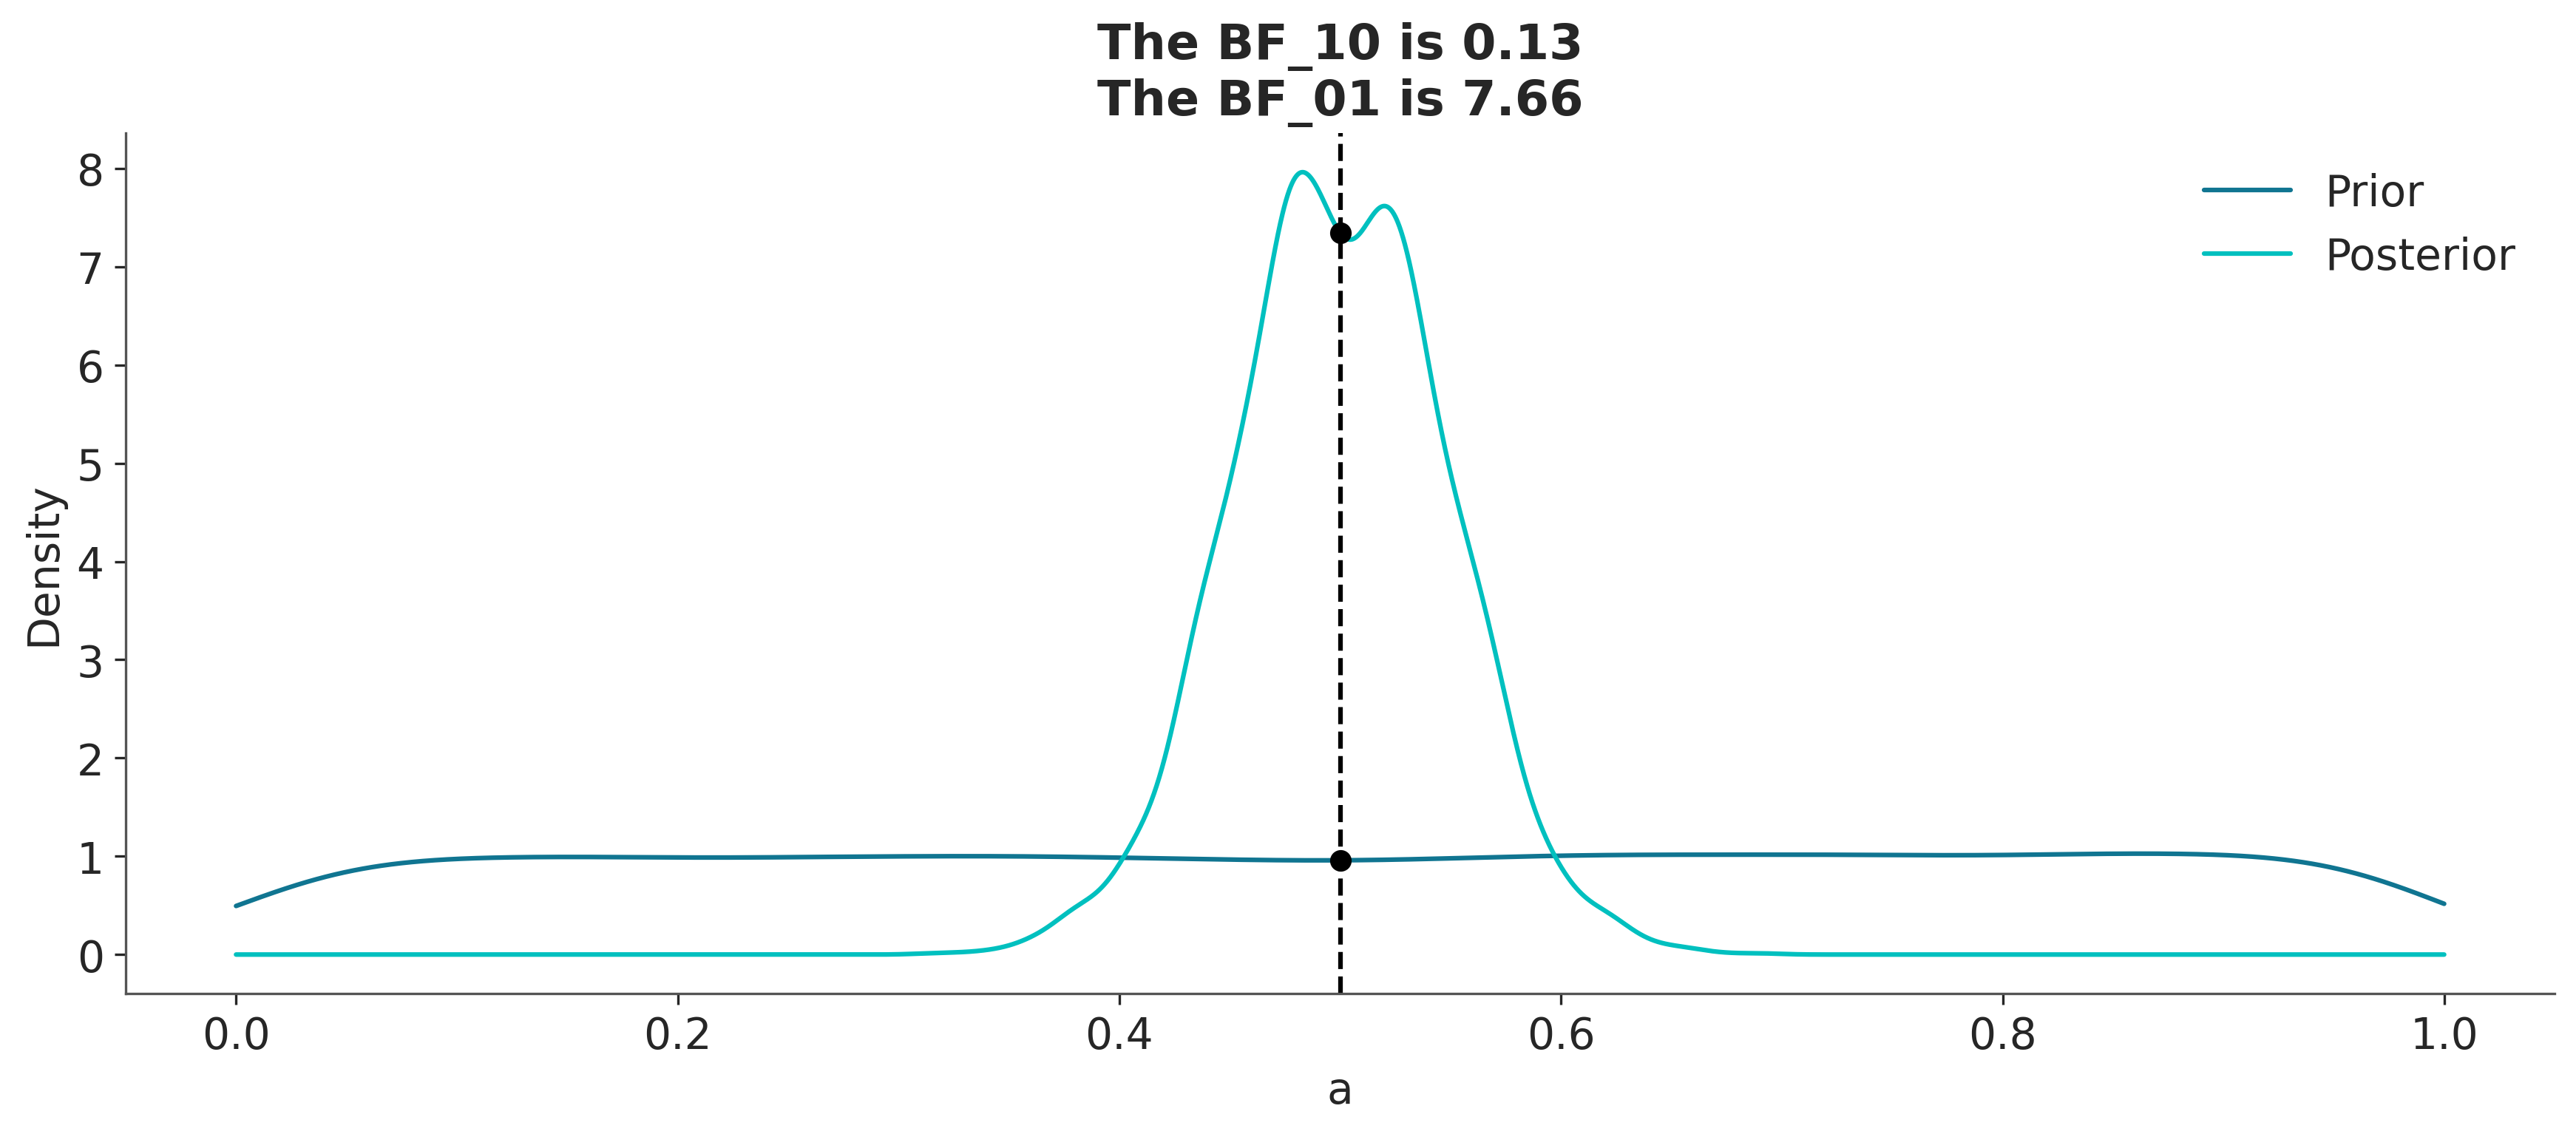

In [20]:
az.plot_bf(idata_uni, var_name="a", ref_val=0.5);
# Moderate evidence in favor of the null hypotesis


In [21]:
with pm.Model() as model_conc:
    a = pm.Beta("a", 30, 30)
    yl = pm.Bernoulli("yl", a, observed=y)
    idata_conc = pm.sample(2000, random_seed=42)
    idata_conc.extend(pm.sample_prior_predictive(8000))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [a]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 24 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Sampling: [a, yl]


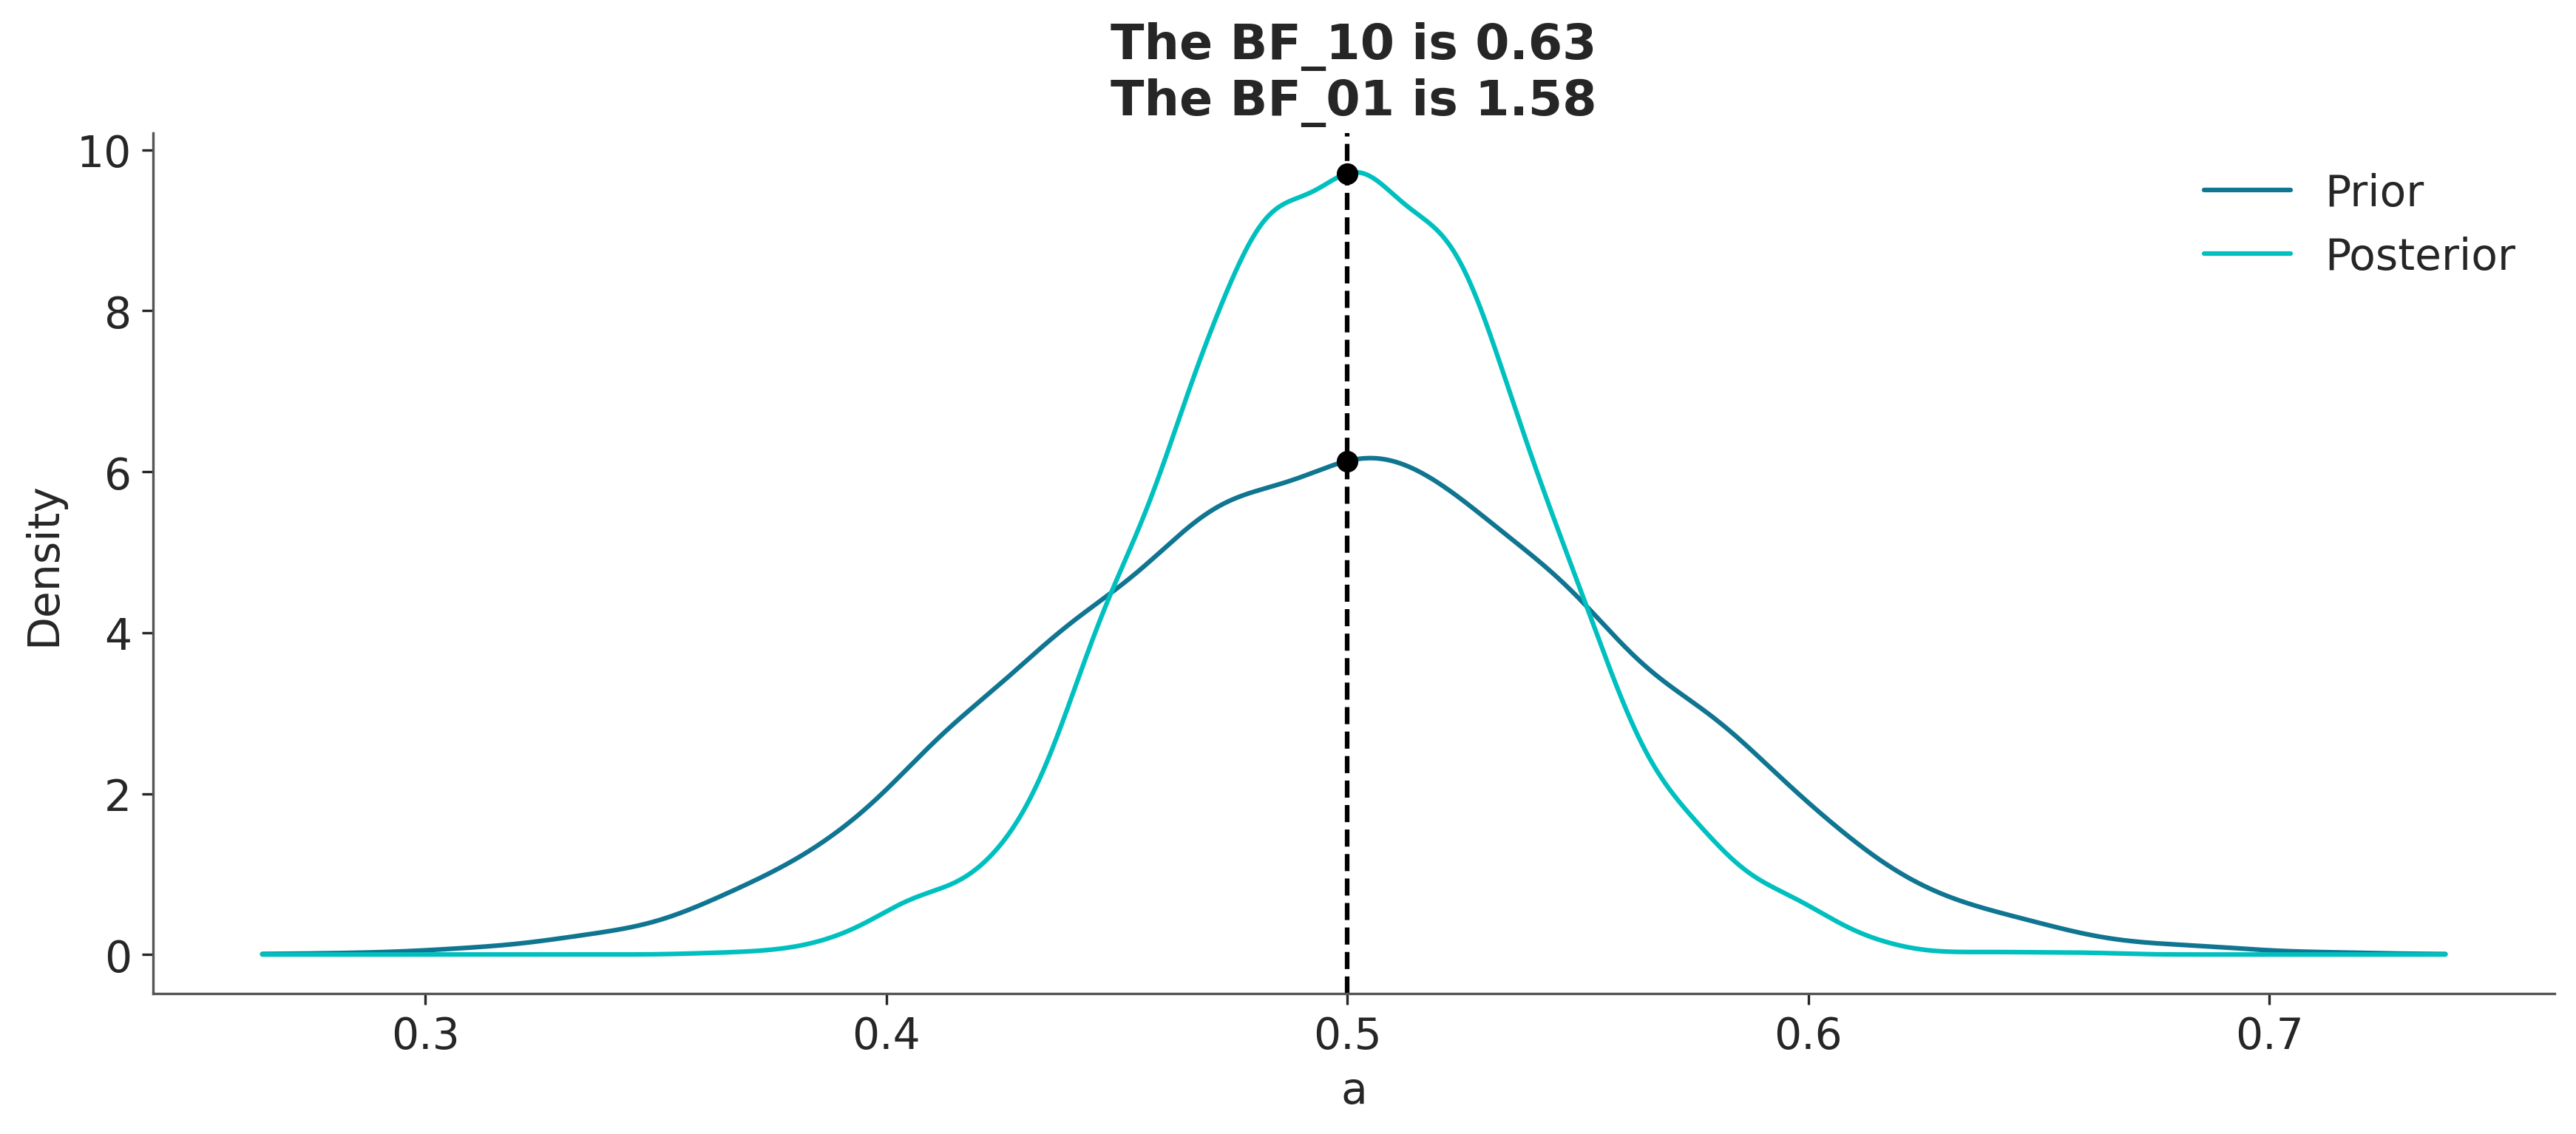

In [22]:
az.plot_bf(idata_conc, var_name="a", ref_val=0.5);